In [8]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from typing import Callable

from mri_data import file_manager as fm

## Load Data

In [9]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/gradient_analysis")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [49]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ignore_structs1 = ["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
mean_choroid_dists = choroid_dists.mean()
new_index = [int(ind) for ind in mean_choroid_dists.index]
mean_choroid_dists.index = new_index

dists_newcols = {str(i): f"{hips_thomas_ref[i]}_dist" for i in hips_thomas_ref.index}
choroid_dists = choroid_dists.rename(columns=dists_newcols)
choroid_dists_z = choroid_dists.apply(stats.zscore, nan_policy="omit")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
                                index_col="index")
# mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_choroid_struct_SDT.csv",
                                # index_col="index")
mni_ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_ventricle_centroid_centroid_dists.csv",
                                index_col="index")

## Functions

In [11]:
def linear_model(x, a, b):
    return a*x + b
def quadratic_model(x, a, b, c):
    return a*x**2 + b*x + c

def cubic_model(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

initial_guess = {linear_model: [1, 0], quadratic_model: [1, 1, 0], cubic_model: [1, 1, 1, 0]}

## Analysis

Text(0.5, 0, 'dzdur')

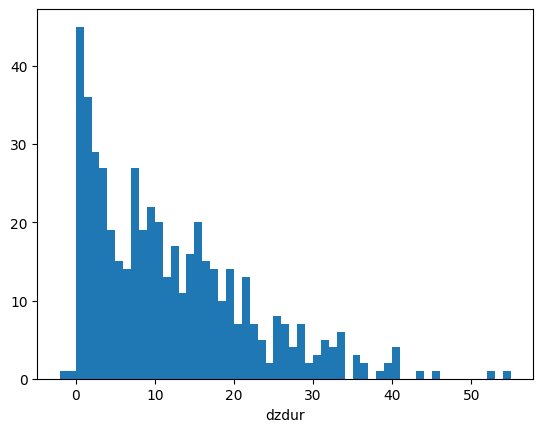

In [5]:
dzdur_min = df.dzdur.min().round()
dzdur_max = df.dzdur.max().round()
# nbins = int((dzdur_max - dzdur_min) / 2) + 2
nbins = int(dzdur_max - dzdur_min) + 1
bins = np.linspace(dzdur_min, dzdur_max, nbins)
plt.hist(df.dzdur, bins=bins)
plt.xlabel("dzdur")

In [6]:
model_data = df.join([df_thomas_z])
model_data = model_data[model_data.dz_type2 == "MS"]
model_data = model_data[model_data.dzdur <= 32]
model_data['dzdur_bin'] = np.digitize(model_data['dzdur'], bins)
numeric_cols = model_data.select_dtypes("number").columns

model_data2 = pd.DataFrame()
rows = []
inds = []
for bin in model_data.dzdur_bin.unique():
    data_to_concat = model_data[model_data.dzdur_bin == bin]
    rows.append(data_to_concat[numeric_cols].mean())
    inds.append(bin)
model_data2 = pd.DataFrame(rows, index=inds)
model_data2.sort_index(inplace=True)

In [50]:
slopes = []
pvals = []
r2 = []
index = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1', "GP_33", "Amy_34"])].index
# index = hips_thomas_ref[thalamic_nuclei].index
for struct_ind in index:
    struct_name = hips_thomas_ref[struct_ind]
    result = stats.linregress(model_data2.dzdur, model_data2[struct_name])
    slopes.append(result.slope)
    pvals.append(result.pvalue)
    r2.append(result.rvalue**2)

data_struct = pd.DataFrame({'slope': slopes, 'pvals': pvals, 'r2': r2}, index=index)
data_struct = data_struct.join([mni_choroid_dists, mean_choroid_dists])
data_struct2 = data_struct[data_struct.pvals < 0.05]
data_struct2

,slope,pvals,r2,left_exposure,right_exposure,0
index,,,,,,
2,-0.034330,7.216293e-08,0.589906,28.724859,28.201181,31.843822
4,-0.030546,2.614454e-04,0.336240,29.301275,28.637189,32.552127
5,-0.029348,1.112856e-04,0.368218,25.154024,24.134354,27.551238
6,-0.035790,1.340303e-07,0.574536,20.982216,20.271701,22.571814
7,-0.031772,9.807938e-06,0.451715,13.337370,12.456556,14.288109
8,-0.044863,5.989890e-08,0.594424,8.712833,8.349248,9.284092
9,-0.032296,1.063784e-05,0.449095,19.527532,18.583537,21.386248
10,-0.043604,7.991212e-08,0.587412,17.274308,16.610573,17.727606
11,-0.036679,1.566230e-05,0.436460,18.029122,17.492163,18.934445


Text(0.5, 1.0, 'Rate of atrophy versus distance from choroid')

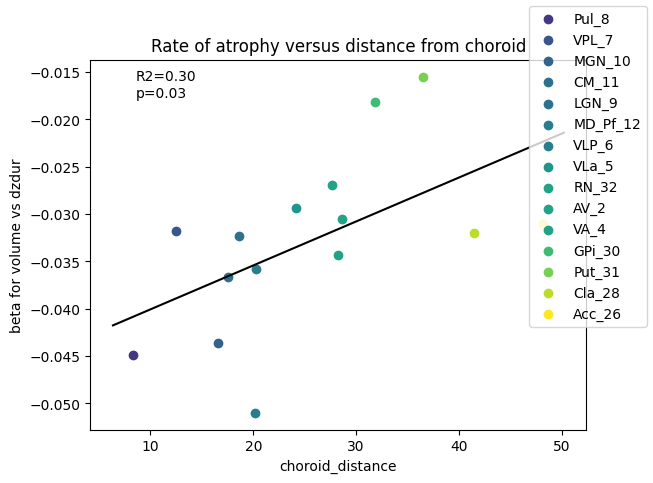

In [51]:
fig, ax = plt.subplots(1)
slope, intercept, r_value, p_value, std_err = stats.linregress(
            data_struct2['right_exposure'], data_struct2['slope'])

data_struct2 = data_struct2.sort_values(by="right_exposure")
for i, row in data_struct2.iterrows():
    c = row.right_exposure / data_struct2.right_exposure.max()
    ax.scatter(row['right_exposure'], row.slope, color=viridis(c), label=hips_thomas_ref[i])

xlims = ax.get_xlim()
ylims = ax.get_ylim()
x = np.array([xlims[0], xlims[1]])
y = slope * x + intercept
ax.plot(x, y, c='black')

text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
ax.text(text_x, text_y, text, fontsize=10)
fig.legend()
plt.xlabel("choroid_distance")
plt.ylabel("beta for volume vs dzdur")
plt.title("Rate of atrophy versus distance from choroid")

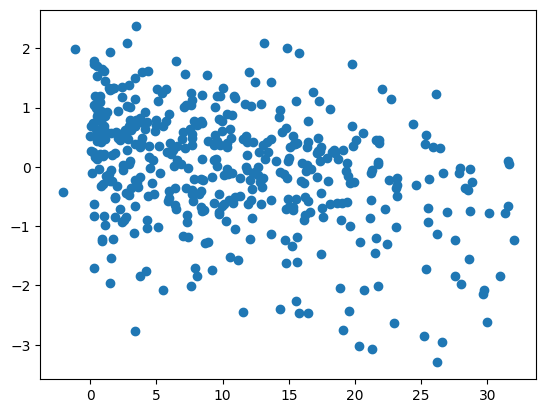

In [17]:
plt.scatter(model_data['dzdur'], model_data['MD_Pf_12'])

AV_2
[6.573408484200627e-12, 0.006634239634920269]


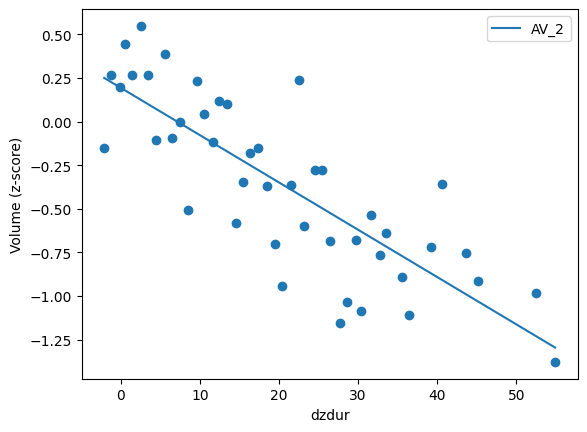

VA_4
[3.2023044261864086e-06, 0.059363045313146956]


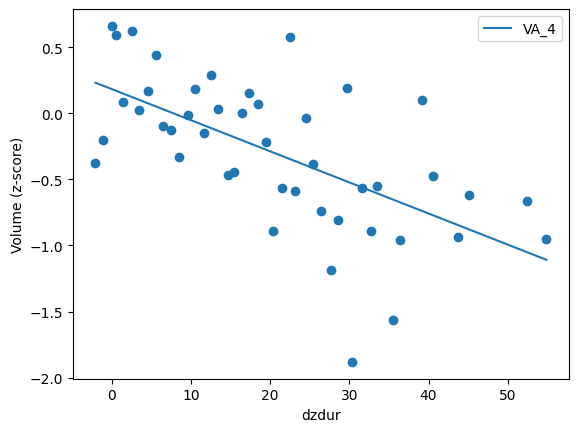

VLa_5
[1.0376905840159267e-06, 0.02167109951498869]


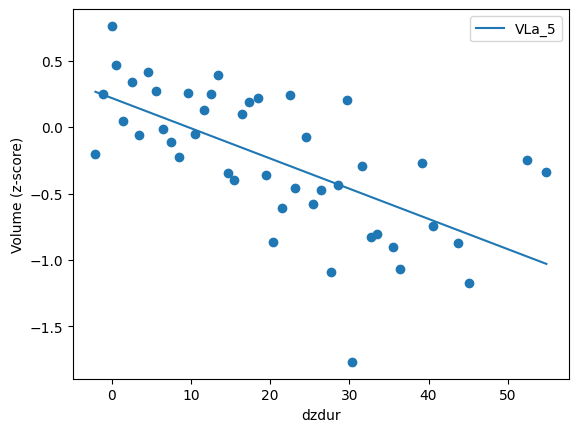

VLP_6
[8.13980728375796e-06, 0.04797369453472833]


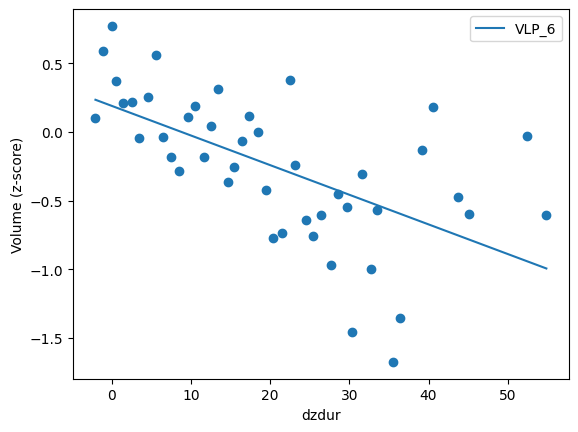

VPL_7
[3.9439428922705133e-07, 0.042121358303918166]


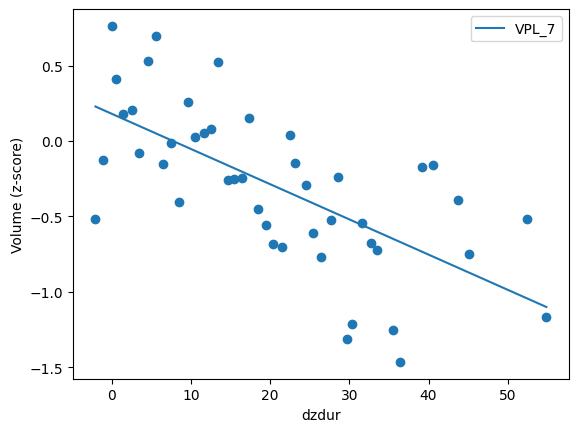

Pul_8
[2.4805070331090917e-08, 0.034856803968416505]


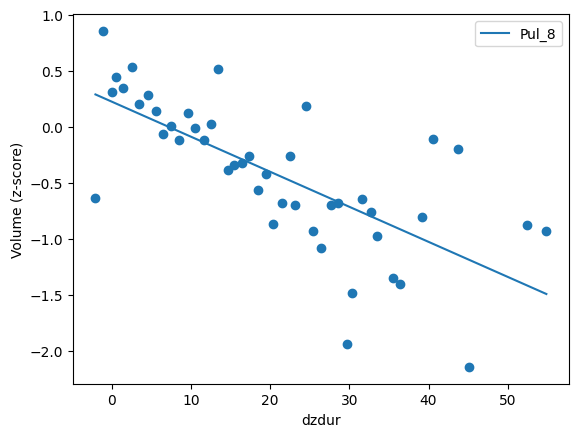

LGN_9
[6.491601782121492e-06, 0.14793358072906326]


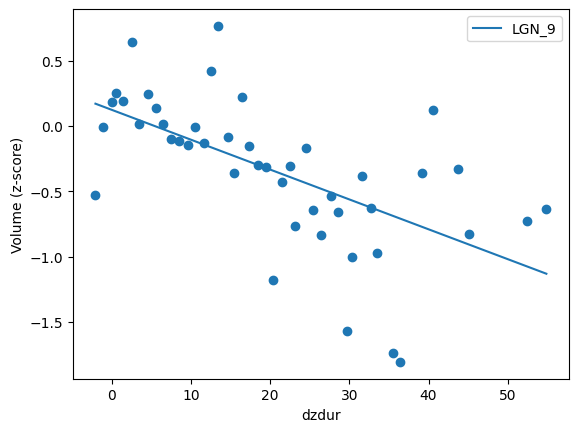

MGN_10
[6.431443078103172e-08, 0.007971238775627776]


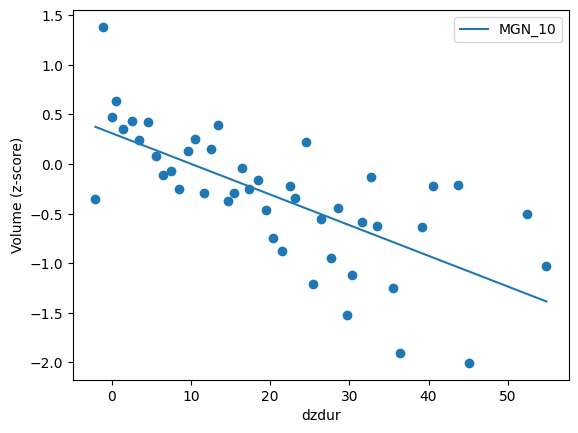

CM_11
[4.337928314890327e-06, 0.036992333211621986]


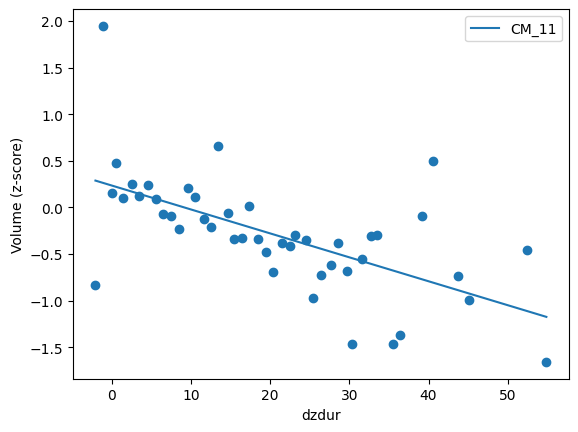

MD_Pf_12
[1.323148535181673e-08, 0.005656089912879914]


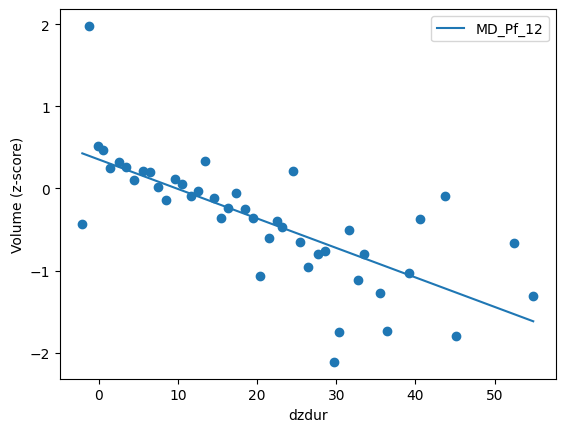

In [12]:
model_data = df.join([df_thomas_z])
model_data = model_data[model_data.dz_type2 == "MS"]
model_data['dzdur_bin'] = np.digitize(model_data['dzdur'], bins)
numeric_cols = model_data.select_dtypes("number").columns

model_data2 = pd.DataFrame()
rows = []
inds = []
for bin in model_data.dzdur_bin.unique():
    data_to_concat = model_data[model_data.dzdur_bin == bin]
    rows.append(data_to_concat[numeric_cols].mean())
    inds.append(bin)
model_data2 = pd.DataFrame(rows, index=inds)
model_data2.sort_index(inplace=True)

model = linear_model

for struct_ind in hips_thomas_ref[thalamic_nuclei].index:
    struct_name = hips_thomas_ref[struct_ind]
    print(struct_name)
    x_data = model_data2.dzdur
    y_data = model_data2[struct_name]


    popt, pcov = curve_fit(model, x_data, y_data, p0=initial_guess[model])
    x_model = np.linspace(x_data.min(), x_data.max(), 100)
    y_model = model(x_model, *popt)

    n = len(y_data)
    p = len(popt)
    stderr = np.sqrt(np.diag(pcov))
    t_stats = popt / stderr
    p_vals = [(1 - stats.t.cdf(np.abs(t_val), df=n - p)) for t_val in t_stats]
    print(p_vals)

    plt.scatter(model_data2.dzdur, model_data2[struct_name])
    plt.plot(x_model, y_model, label=struct_name)

    plt.xlabel("dzdur")
    plt.ylabel("Volume (z-score)")
    plt.legend()
    plt.show()

In [15]:
perr = np.sqrt(np.diag(pcov))
alpha = 0.05
dof = max(0, len(x_data) - len(popt))  # degrees of freedom
tval = stats.t.ppf(1.0 - alpha / 2., dof)

ci = [(p - tval * err, p + tval * err) for p, err in zip(popt, perr)]

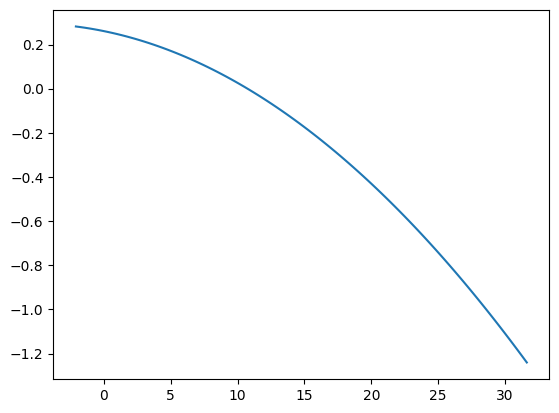

In [17]:
lower_params = [item[0] for item in ci]
y_lower = model(x_model, *lower_params)

upper_params = [item[1] for item in ci]
y_upper = model(x_model, *upper_params)

plt.plot(x_model, y_model)
# plt.fill_between(x_model, y_lower, y_upper, alpha=0.2)

In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data['dz_type5'])], axis=1)

structs = hips_thomas_ref[thalamic_nuclei]
pvals = {}
coefs = {}
interaction_coefs = {}
interaction_p = {}
se = {}
for struct in structs:
    formula = f"{struct} ~ choroid_volume*dzdur + age + Female + tiv"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues['choroid_volume']
    coefs[struct] = res.params['choroid_volume']
    interaction_coefs[struct] = res.params['choroid_volume:dzdur']
    interaction_p[struct] = res.pvalues['choroid_volume:dzdur']

regression_results = pd.DataFrame(
        {
            "coef": coefs,
            "pvals": pvals,
            "interaction_coefs": interaction_coefs,
            "interaction_p": interaction_p
        }
    )  
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.index:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))
regression_results.index = new_index

regression_results = regression_results.sort_values(by="interaction_coefs")
regression_results

,struct,coef,pvals,interaction_coefs,interaction_p
5,VLa_5,-0.107260,7.950843e-03,-0.062678,0.111227
7,VPL_7,-0.274479,4.130462e-10,-0.046530,0.267921
4,VA_4,-0.097822,1.452547e-02,-0.046185,0.236026
6,VLP_6,-0.252520,2.000467e-09,-0.033985,0.399242
9,LGN_9,-0.381041,5.435329e-16,-0.031983,0.470324
2,AV_2,-0.243087,3.095428e-08,0.010362,0.805834
8,Pul_8,-0.427936,6.849019e-23,0.017728,0.659224
12,MD_Pf_12,-0.444934,1.507526e-24,0.020159,0.615066
11,CM_11,-0.354047,4.682365e-17,0.040012,0.312667
10,MGN_10,-0.361936,6.426439e-18,0.041144,0.295711


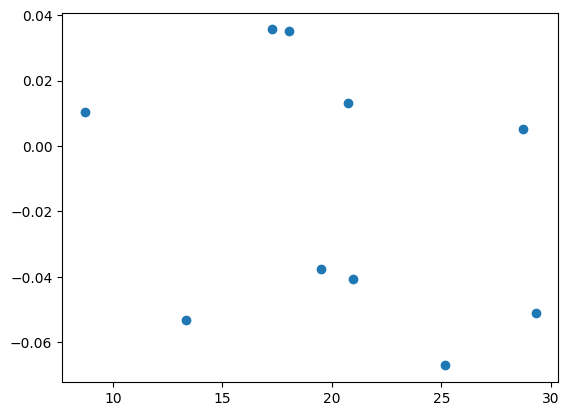

In [ ]:
regression_results['dist'] = mni_choroid_dists['left_exposure']
plt.scatter(regression_results['dist'], regression_results['interaction_coefs'])